In [2]:
import numpy as np
import pandas as pd
import re
from pandas import DataFrame
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import cross_validation
from sqlalchemy import create_engine
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Predicting invalidation

First, we pull down all of the patents that have ever been brought before the PTAB

In [7]:
# Connecting to the db
host_db = "cal-patent-lab.chhaitskv8dz.us-west-2.rds.amazonaws.com"
username = "teamrocket"
password = "teamrocket"
db = "teamrocket"

engine = create_engine("mysql://{}:{}@{}/{}".format(
    username, password, host_db, db))
connection = engine.connect()
q = "SELECT case_id, patent_id, invalidated, denied, filing_date, decision_date FROM ptab_cases"
ptab_patents = pd.read_sql(q, engine)
connection.close()

ptab_patents[:20]

,case_id,patent_id,invalidated,denied,filing_date,decision_date
0,CBM2012-00001,6553350,1.0,0.0,2012-09-16,2013-01-09
1,CBM2012-00002,6064970,1.0,0.0,2012-09-16,2013-01-25
2,CBM2012-00003,8140358,1.0,0.0,2012-09-16,2013-02-12
3,CBM2012-00004,6064970,1.0,0.0,2012-09-16,2013-01-25
4,CBM2012-00005,6675151,1.0,0.0,2012-09-21,2013-01-23
5,CBM2012-00007,5361201,1.0,0.0,2012-09-19,2013-01-31
6,CBM2012-00010,7124088,1.0,0.0,2012-09-29,2013-02-25
7,CBM2012-00011,7124088,0.0,1.0,2012-09-29,2013-02-25
8,CBM2013-00001,7877269,0.0,1.0,2012-10-03,2013-02-27
9,CBM2013-00002,7877269,1.0,0.0,2012-10-02,2013-02-27


In [19]:
# Next, we want to grab the claims text associated with each patent and insert it into the dataframe

host_db = "rosencrantz.berkeley.edu"
username = "uspto"
password = "ferrisbueller"
db = "uspto"

engine = create_engine("mysql://{}:{}@{}/{}".format(
    username, password, host_db, db))
connection = engine.connect()

patent_id = int(ptab_patents.patent_id[:1])

In [102]:
# Inserting concatenated claim text into ptab_patents

found = list()
for idx, patent_id in enumerate(ptab_patents.patent_id):
    q = "SELECT text from uspto.claim where patent_id = '{}'".format(patent_id)
    claims = pd.read_sql(q, engine)
    claims_concat = claims.text.str.cat()
    ptab_patents.loc[ptab_patents.patent_id == '{}'.format(patent_id), 'claim_text'] = claims_concat
    found.append(not claims.empty)
    if idx % 100 == 0:
        print("Processing patent {}".format(idx))

Processing patent 0
Processing patent 100
Processing patent 200
Processing patent 300
Processing patent 400
Processing patent 500
Processing patent 600
Processing patent 700
Processing patent 800
Processing patent 900
Processing patent 1000
Processing patent 1100
Processing patent 1200
Processing patent 1300
Processing patent 1400
Processing patent 1500
Processing patent 1600
Processing patent 1700
Processing patent 1800
Processing patent 1900
Processing patent 2000
Processing patent 2100
Processing patent 2200
Processing patent 2300
Processing patent 2400
Processing patent 2500
Processing patent 2600
Processing patent 2700
Processing patent 2800
Processing patent 2900
Processing patent 3000
Processing patent 3100
Processing patent 3200
Processing patent 3300
Processing patent 3400
Processing patent 3500
Processing patent 3600
Processing patent 3700
Processing patent 3800
Processing patent 3900
Processing patent 4000
Processing patent 4100
Processing patent 4200
Processing patent 4300


In [106]:
# ptab_patents.to_pickle('ptab_patents.pkl')

Loading pickled data, deduplicating patents, and running model

In [3]:
ptab_patents = pd.read_pickle('ptab_patents.pkl')

In [4]:
# De-duplicating patents

df = ptab_patents.dropna(axis=0, how='any')
mask = (ptab_patents.claim_text.str.len() > 1)
df = df.loc[mask]
dups = df.duplicated(subset='claim_text', keep='first')
df = df.loc[~dups]


X = df.claim_text.as_matrix()
y = df.invalidated.as_matrix()

In [12]:
sum(ptab_patents.invalidated.value_counts())

3645

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def train_model(X, y, classifier):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X, y, test_size=0.2, random_state=20)

    tfidf = TfidfVectorizer()
    tfidf.fit(X)
    X_train = tfidf.transform(X_train)
    X_test = tfidf.transform(X_test)

    model = classifier.fit(X_train, y_train)
    
#     logistic_class = LogisticRegression(dual=True)
#     model = logistic_class.fit(X_train, y_train)

    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))

    print("Training accuracy is {0}".format(model.score(X_train, y_train)))
    print("Testing accuracy is {0}".format(model.score(X_test, y_test)))
    print("Precision is {0}".format(precision))
    print("Recall is {0}".format(recall))

    vals = df.invalidated.value_counts()
    print("Outcome of guessing is {}".format(float(vals[0])/float(sum(vals))))
    print("N is {0}".format(sum(vals)))
    
    return model, X_test, y_test

In [14]:
model, X_test, y_test = train_model(X, y)

Training accuracy is 0.981424148607
Testing accuracy is 0.702786377709
Precision is 0.659793814433
Recall is 0.503937007874
Outcome of guessing is 0.618575851393
N is 1615


Recall is high when we keep our false negatives low and precision is high when we keep our false positives low. Basically, this classifier is overindexing on precision relative to recall. A next step here would be to look at tradeoffs between precision and recall between different probabalistic classifiers. We probably also want to play with regularization.

# Predicting denials

In [15]:
null_denied_counts = ptab_patents.denied.notnull().value_counts()
print("Out of {0} total cases, {1} have null for their denied status".format(sum(null_denied_counts), null_denied_counts[1]))

Out of 6450 total cases, 3645 have null for their denied status


In [16]:
dup_patent_counts = ptab_patents.duplicated(subset='patent_id', keep='first').value_counts()
print("Out of {0} total cases, {1} are on duplicate patents".format(sum(dup_patent_counts), dup_patent_counts[1]))

Out of 6450 total cases, 2487 are on duplicate patents


__Data cleaning__: Suppose we drop the nulls and duplicate patents (for simplicity)

In [44]:
# First get rid of patents where we cannot find the claim text
mask = (ptab_patents.claim_text.str.len() > 1)
df = ptab_patents.loc[mask]

# Then we get rid of patents with no 'denied' status
null_denied = df.denied.isnull()
df = df[~null_denied]

# Finally, we want to get rid of duplicates
# dups = df.duplicated(subset='patent_id', keep='first')
# df = df[~dups]

X = df.claim_text.as_matrix()
y = df.denied.as_matrix()

In [52]:
svc_class = SVC(C=1, kernel='linear')
model, X_test, y_test = train_model(X, y, svc_class)

Training accuracy is 0.869477911647
Testing accuracy is 0.706827309237
Precision is 0.693037974684
Recall is 0.817164179104
Outcome of guessing is 0.613253012048
N is 2490


Linear SVC, C=1
Training accuracy is 0.869477911647
Testing accuracy is 0.706827309237
Precision is 0.693037974684
Recall is 0.817164179104
Outcome of guessing is 0.613253012048
N is 2490
Linear SVC, C=0.1
Training accuracy is 0.59186746988
Testing accuracy is 0.550200803213
Precision is 0.545643153527
Recall is 0.981343283582
Outcome of guessing is 0.613253012048
N is 2490
Linear SVC, C=0.01
Training accuracy is 0.59186746988
Testing accuracy is 0.550200803213
Precision is 0.545643153527
Recall is 0.981343283582
Outcome of guessing is 0.613253012048
N is 2490
Gaussian kernel SVC, C=1
Training accuracy is 0.561746987952
Testing accuracy is 0.538152610442
Precision is 0.538152610442
Recall is 1.0
Outcome of guessing is 0.613253012048
N is 2490


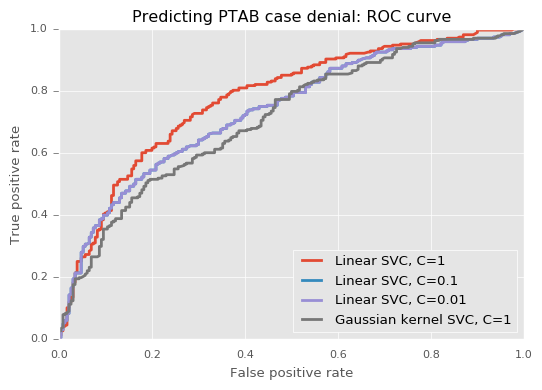

In [67]:
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
import matplotlib

clfs = [("Linear SVC, C=1", SVC(C=1, kernel='linear')), 
        ("Linear SVC, C=0.1" , SVC(C=.1, kernel='linear')), 
        ("Linear SVC, C=0.01", SVC(C=.1, kernel='linear')),
        ("Gaussian kernel SVC, C=1", SVC(C=1, kernel='rbf'))]

# clfs = {"Linear SVC, C=1" : SVC(C=1, kernel='linear')}
# Random forest algorithm

plt.figure()
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 8}) 

for (name, classifier) in clfs:
    print(name)
    model, X_test, y_test = train_model(X, y, classifier)
    y_score = model.decision_function(X_test)
    fpr = dict()
    tpr = dict()
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             lw=lw, label=name)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Predicting PTAB case denial: ROC curve')
    plt.legend(loc=4)

plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='on',         # ticks along the bottom edge are off
    right='off')       # ticks along the top edge are off

Next step: ROC curves, cross-validation